<h1> Netflix Movie Rating Classifier </h1>

The goal of this project is to utilize big data techniques to build a classifier model to predict the rating that a user will give to a movie. The classifier model will be build using the Netflix challenge dataset (https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data).
<br>
1 million rows will be used in the project to validate the process and serves as a proof-of-concept for scaling the pipeline to the full dataset in the future.
<br>
EDA involves exploration of distribution of users and movie statistics, comparison of big data technology such as pyspark, dask, and databricks.
<br>
Data will be reformatted, normalized, and manipulated to allow for similarity calculations. A weighted average of k top similar users will be used to predict the rating for a given (user, movie) pair. Code for the proposed project is documented below.

In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j
!pip install dask[complete]
!pip install dask_ml

<h2>Part 1: Extraction of Data.</h2>
<br>
The first data file was downloaded from Kaggle and contains 24M rows of data. The first 1M rows will be extracted and used for downstream analysis.

In [5]:
original_file = '/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/combined_data_1.csv'
output_file_1M = '/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/netflix_data1M.csv'
!head -1000000 '/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/combined_data_1.csv' > '/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/netflix_data1M.csv'

Exploratory Data Analysis

In [9]:
# get counts of each rating
!cat '/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/netflix_data1M.csv' | grep -c ",1,"
!cat '/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/netflix_data1M.csv' | grep -c ",2,"
!cat '/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/netflix_data1M.csv' | grep -c ",3,"
!cat '/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/netflix_data1M.csv' | grep -c ",4,"
!cat '/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/netflix_data1M.csv' | grep -c ",5,"

44851
96545
277190
351854
229335


In [17]:
# view the structure of the data
!head -25 '/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/netflix_data1M.csv'

1:
1488844,3,2005-09-06
822109,5,2005-05-13
885013,4,2005-10-19
30878,4,2005-12-26
823519,3,2004-05-03
893988,3,2005-11-17
124105,4,2004-08-05
1248029,3,2004-04-22
1842128,4,2004-05-09
2238063,3,2005-05-11
1503895,4,2005-05-19
2207774,5,2005-06-06
2590061,3,2004-08-12
2442,3,2004-04-14
543865,4,2004-05-28
1209119,4,2004-03-23
804919,4,2004-06-10
1086807,3,2004-12-28
1711859,4,2005-05-08
372233,5,2005-11-23
1080361,3,2005-03-28
1245640,3,2005-12-19
558634,4,2004-12-14
2165002,4,2004-04-06


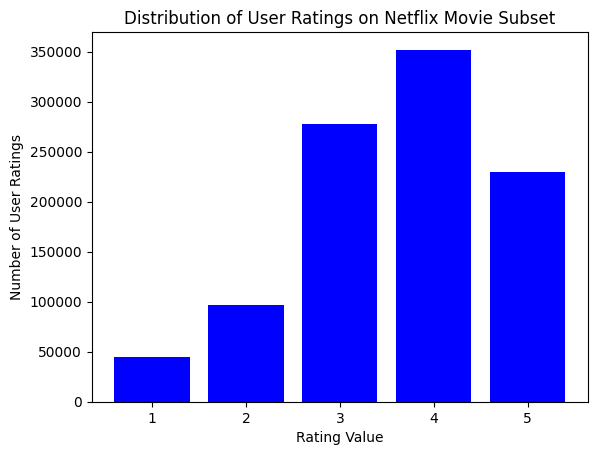

62 118413


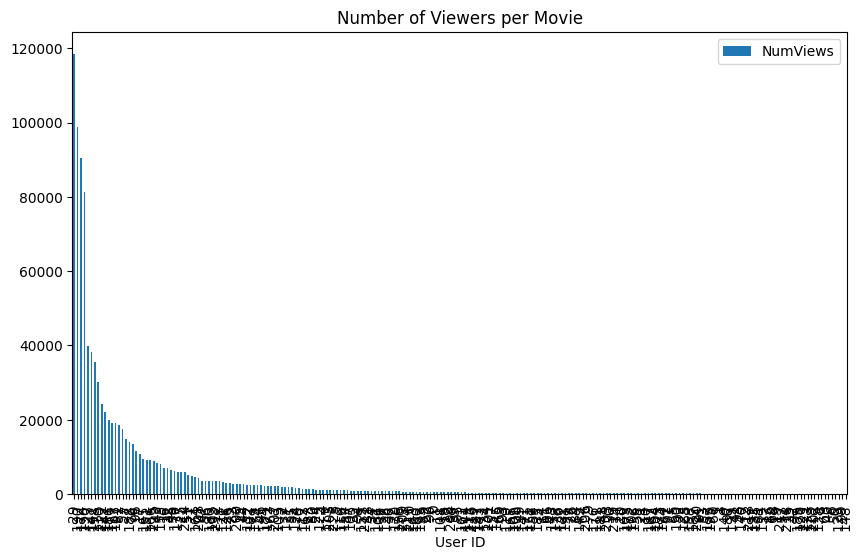

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

y = [44851,96545,277190,351854,229335]
x = [1,2,3,4,5]
plt.bar(x, y, color='blue')

# Adding labels and title
plt.xlabel('Rating Value')
plt.ylabel('Number of User Ratings')
plt.title('Distribution of User Ratings on Netflix Movie Subset')

# Display the plot
plt.show()

filename = '/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/user movie counts.txt'
results = pd.read_csv(filename, sep = " ",names = ["Movie", "NumViews"],dtype={
    'Movie': 'string',
    'NumViews': 'int64'}, header = None)
results = results.sort_values(by=['NumViews'], ascending = False)
# Plot the data using a bar plot
results.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Viewers per Movie')
plt.xlabel('User ID')
print(min(results['NumViews']),max(results['NumViews']))

The original csv file is not conducive for analysis. Let's reformat it so that the movieId's are on the same row as the rest of the data. This makes it easier to load in as a dataframe and do matrix operations.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

data_path = '/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/netflix_data1M.csv'

# Initialize Spark session
spark = SparkSession.builder.appName("NetflixChallenge").getOrCreate()
schema = StructType([
    StructField("MovieID", IntegerType(), True),
    StructField("CustomerID", IntegerType(), True),
    StructField("Rating", IntegerType(), True),
    StructField("Date", StringType(), True)
])
df = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema)
customer_hash = {}
count = 0
# Read the data
raw_data = spark.read.text(data_path)
movie_id = 1
with open(data_path, "r") as file:
    for line in file:
        # Assuming each line in the text file is in the format "CustomerID,Date"

        if ":" in line:
          movie_id = line.strip().split(":")[0]
        else:
          customer_id, rating,date = line.strip().split(',')
          with open('/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/netflix_data.csv',"a") as output:
            customer_id, rating,date = line.strip().split(',')
            output.write(movie_id+","+customer_id+","+ rating+","+ date+"\n")
          try:
            customer_hash[customer_id].append(movie_id)
          except:
            customer_hash[customer_id] = [movie_id]


In [28]:
# count how many movies an individual watched
freq_hash = {}
for k,v in customer_hash.items():
  v = len(set(v))
  try:
    freq_hash[v] += 1
  except:
    freq_hash[v] = 1

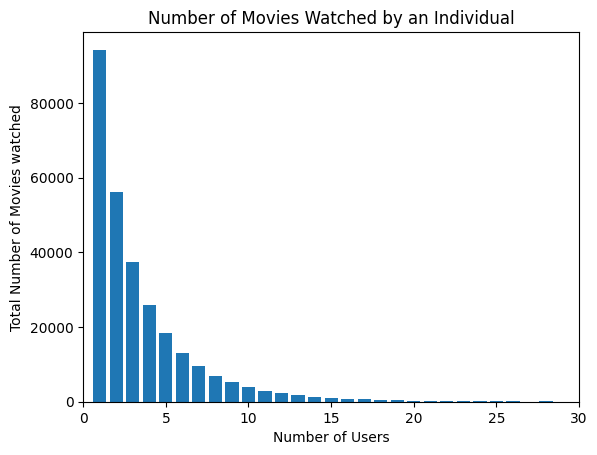

In [52]:

# Limit the range of x-axis to display specific buckets
plt.bar(freq_hash.keys(), freq_hash.values())

# Adding labels and title
plt.xlabel('Number of Users')
plt.ylabel('Total Number of Movies watched')
plt.title("Number of Movies Watched by an Individual")
plt.xlim(0,30)
# Display the plot
plt.show()

Vectorize each movie and save results to file. Ratings are normalized by subtracting the users average rating to account for user bias.

In [ ]:
from sklearn.model_selection import train_test_split
import os

filename = '/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/netflix_data.csv'
outfile = '/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/movie_vectors/'

movie_names = set()
last_user = 1
count = 0
values = {}
# read data
with open(filename, "r") as f0:
  for line in f0.readlines():
    data = line.split(",")
    user_id = data[0]
    movie_id = data[1]
    rating = data[2]
    movie_names.add(movie_id)
    # aggrgate by movi ID
    if user_id == last_user:
      values[movie_id] = int(rating)
    else:
      # nw MovieID found, so lets dump last aggregation to file
      mean_val = np.array([x for x in values.values() if x != 0]).mean()
      final_hash = {}
      for m in movie_names:
        if m in values:
          final_hash[m] = [values[m]-mean_val]
        else:
          final_hash[m] = [0]
      values = {movie_id:int(rating)}
      final_df = pd.DataFrame().from_dict(final_hash)
      print(user_id, len(final_hash))
      final_df.to_csv(outfile+"movie_"+str(last_user)+"_"+str(count)+".csv")
      last_user = user_id
      count += 1
# do this again since the last elmnt hasnt been written yet
mean_val = np.array([x for x in values.values() if x != 0]).mean()
final_hash = {}
for m in movie_names:
  if m in values:
    final_hash[m] = [values[m]-mean_val]
  else:
    final_hash[m] = [0]
  final_df = pd.DataFrame().from_dict(final_hash)
  final_df.to_csv(outfile+"movie_"+str(last_user)+"_"+str(count)+".csv")


folder_path = '/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/movie_vectors/'

# Get a list of all files in the folder
all_files = os.listdir(folder_path)
# 80% train
train_files, temp_files = train_test_split(all_files, test_size=0.2, random_state=42)
# 10% val, 10% test
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

# Print the number of files in each set
print(f"Number of training files: {len(train_files)}")
print(f"Number of validation files: {len(val_files)}")
print(f"Number of test files: {len(test_files)}")

Compute the cosine similarity between each validation movie against the movies in the training dataset.

In [ ]:
top_k = [5,10,15,20]
results = {}
num_intersec = [0,0]
#computes cosine sim between 2 vecttors
def compute_cosine_sim(v1, v2, v1_user, v2_user):
  common_movies = v1.columns.intersection(v2.columns)
  num_intersec[0] += len(common_movies)
  num_intersec[1] += 1
  v1_subset = np.array(v1[common_movies])
  v2_subset = np.array(v2[common_movies])
  dot_prod = v1_subset[0].dot(v2_subset[0])
  v1_mag = np.linalg.norm(v1)
  v2_mag = np.linalg.norm(v2)
  try:
    return dot_prod/(v1_mag*v2_mag)
  except:
    print("error!", v1_user, v2_user)
    return 0


# load the training data
train = {}
for t_user in train_files:
  t1 = pd.read_csv(folder_path+"/"+t_user)
  train[t_user] = t1
# compute cosine sim between each pair of validation and training data
for v1_user in val_files:
  v1 = pd.read_csv(folder_path+"/"+v1_user)
  temp = []
  for v2_user,v2 in train.items():
    temp.append([compute_cosine_sim(v1,v2,v1_user, v2_user),v2_user])
  results[v1_user] = temp

Sort cosine similarities, extract the top k, and make rating predictions. Write results to file.

In [ ]:
# returns predicted ratings
def get_predictions(t_users, movie):
  t_preds = [train[t_user[1]][movie].iloc[0]*t_user[0] if movie in train[t_user[1]].columns else mean_data[t_user[1]] for t_user in t_users]
  try:
    return str(round(sum(t_preds)/len(t_preds)))
  except:
    print("error calculating predictions")
predictions = {}
for v1, res in results.items():
  #sort by cosine sim scores
  res.sort(reverse = True)
  v1_data = pd.read_csv(folder_path+"/"+v1)
  with open('/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/val_results/'+v1,'a') as f0:
    f0.write("Name,"+",".join(v1_data.columns[1:])+"\n")
    f0.write("Actual,"+",".join([str(round(v1_data[movie_name].iloc[0]+mean_data[v1])) for movie_name in v1_data.columns])+"\n")
    for k in top_k:
      temp = []
      for mov in v1_data.columns[1:]:
        temp.append(get_predictions(res[:k], mov))
      f0.write("top: "+str(k)+","+",".join(temp)+"\n")

Select best k value using the validation dataset

In [117]:
def calculate_rmse(actual_values, predicted_values):
    n = len(actual_values)
    rmse = np.sqrt(np.sum((actual_values - predicted_values) ** 2) / n)
    return rmse


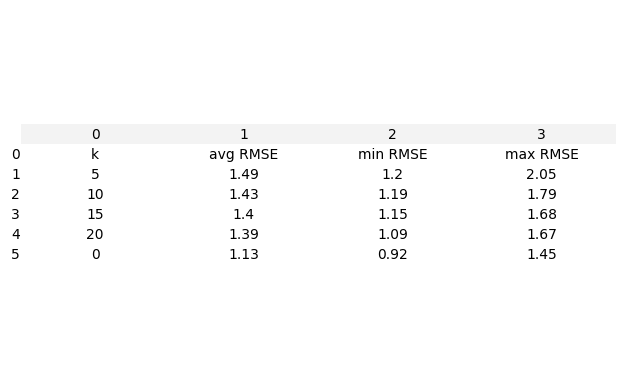

In [128]:
df2 = [["k", "avg RMSE", "min RMSE", "max RMSE"],[5,1.49,1.20,2.05],[10,1.43,1.19,1.79],[15,1.40,1.15,1.68],[20,1.39,1.09,1.67],[0,1.13,0.92,1.45]]
df = pd.DataFrame(df2)

# Create a figure and axis
fig, ax = plt.subplots()

# Create a table and add it to the axis
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', cellLoc='center', colColours=['#f3f3f3']*df.shape[1])

# Modify table font size and cell padding
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
for key, cell in table.get_celld().items():
    cell.set_linewidth(0)

# Hide axis
ax.axis('off')

# Display the plot
plt.show()


In [77]:
import pandas as pd
import numpy as np
folder_path = '/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/val_results/'
all_files = os.listdir(folder_path)

results = {"top: 5":[],"top: 10":[],"top: 15":[],"top: 20":[],"baseline":[]}
for res in all_files:
  with open(folder_path+res, "r") as f0:
    df = pd.read_csv(f0, header=0, index_col=0)
    for k in results.keys():
      try:
        results[k].append(calculate_rmse(df.loc["Actual"],df.loc[k]))
      except:
        pass
    df.loc['baseline'] = df.loc["Actual"].mean()
    results["baseline"].append(calculate_rmse(df.loc["Actual"],df.loc["Actual"].mean()))
for k,v in results.items():
  print("mean: " k, ": ", np.array(v).mean())
  print("min: ",k, ": ", np.array(v).min())
  print("max: ",k, ": ", np.array(v).max())


top: 5 :  1.4865311199763516
top: 5 :  1.2030264865216922
top: 5 :  2.0464687117164018
top: 10 :  1.4293928790309547
top: 10 :  1.1878169433498964
top: 10 :  1.7926274070085388
top: 15 :  1.4069649762346512
top: 15 :  1.145361013764591
top: 15 :  1.6794382455192631
top: 20 :  1.3929920479971776
top: 20 :  1.092228439001184
top: 20 :  1.6743413043399495
baseline :  1.1340779202590254
baseline :  0.9218535609974479
baseline :  1.4515830277942994


# New Section

Evaluate on the test dataset

In [125]:
top_k = [5,10,15,20]
results = {}
num_intersec = [0,0]
def compute_cosine_sim(v1, v2, v1_user, v2_user):
  common_movies = v1.columns.intersection(v2.columns)
  num_intersec[0] += len(common_movies)
  num_intersec[1] += 1
  v1_subset = np.array(v1[common_movies])
  v2_subset = np.array(v2[common_movies])
  dot_prod = v1_subset[0].dot(v2_subset[0])
  v1_mag = np.linalg.norm(v1)
  v2_mag = np.linalg.norm(v2)
  try:
    return dot_prod/(v1_mag*v2_mag)
  except:
    print("error!", v1_user, v2_user)
    return 0

folder_path = '/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/user_vectors/'


# compute cosine sim between each pair of validation and training data
for v1_user in test_files:
  v1 = pd.read_csv(folder_path+v1_user)
  temp = []
  for v2_user,v2 in train.items():
    temp.append([compute_cosine_sim(v1,v2,v1_user, v2_user),v2_user])
  results[v1_user] = temp

predictions = {}
for v1, res in results.items():
  res.sort(reverse = True)
  v1_data = pd.read_csv(folder_path+"/"+v1)
  with open('/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/test_results/'+v1,'a') as f0:
    f0.write("Name,"+",".join(v1_data.columns[1:])+"\n")
    f0.write("Actual,"+",".join([str(round(v1_data[movie_name].iloc[0]+mean_data[v1])) for movie_name in v1_data.columns])+"\n")
    for k in top_k:
      temp = []
      for mov in v1_data.columns[1:]:
        temp.append(get_predictions(res[:k], mov))
      f0.write("top: "+str(k)+","+",".join(temp)+"\n")


In [126]:
folder_path = '/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/test_results/'
all_files = os.listdir(folder_path)

results = {"top: 20":[],"baseline":[]}
for res in all_files:
  with open(folder_path+res, "r") as f0:
    df = pd.read_csv(f0, header=0, index_col=0)
    results["top: 20"].append(calculate_rmse(df.loc["Actual"],df.loc["top: 20"]))
    df.loc['baseline'] = df.loc["Actual"].mean()
    results["baseline"].append(calculate_rmse(df.loc["Actual"],df.loc["Actual"].mean()))

for k,v in results.items():
  print(k, ": ", np.array(v).mean())
  print(k, ": ", np.array(v).min())
  print(k, ": ", np.array(v).max())

top: 20 :  1.3475771453341694
top: 20 :  1.0731762946775407
top: 20 :  1.8568791021496256
baseline :  1.103679948572902
baseline :  0.861281824430189
baseline :  1.4197256999998664


Un-elegant way to compute the mean since I normalized the ratings, but now need to them back to normal to compare with the predictions.

In [90]:
data = [
    ['user_1_1.csv', 3.75], ['user_2_2.csv', 3.73], ['user_3_3.csv', 3.67], ['user_4_4.csv', 3.63], ['user_5_5.csv', 3.73],
    ['user_6_6.csv', 3.60], ['user_7_7.csv', 3.58], ['user_8_8.csv', 3.28], ['user_9_9.csv', 3.28], ['user_10_10.csv', 3.28],
    ['user_11_11.csv', 3.28], ['user_12_12.csv', 3.29], ['user_13_13.csv', 3.29], ['user_14_14.csv', 3.29], ['user_15_15.csv', 3.29],
    ['user_16_16.csv', 3.27], ['user_17_17.csv', 3.19], ['user_18_18.csv', 3.36], ['user_19_19.csv', 3.36], ['user_20_20.csv', 3.36],
    ['user_21_21.csv', 3.36], ['user_22_22.csv', 3.36], ['user_23_23.csv', 3.36], ['user_24_24.csv', 3.35], ['user_25_25.csv', 3.37],
    ['user_26_26.csv', 3.30], ['user_27_27.csv', 3.30], ['user_28_28.csv', 3.57], ['user_29_29.csv', 3.57], ['user_30_30.csv', 3.71],
    ['user_31_31.csv', 3.71], ['user_32_32.csv', 3.72], ['user_33_33.csv', 3.74], ['user_34_34.csv', 3.74], ['user_35_35.csv', 3.74],
    ['user_36_36.csv', 3.74], ['user_37_37.csv', 3.74], ['user_38_38.csv', 3.73], ['user_39_39.csv', 3.73], ['user_40_40.csv', 3.72],
    ['user_41_41.csv', 3.72], ['user_42_42.csv', 3.72], ['user_43_43.csv', 3.72], ['user_44_44.csv', 3.72], ['user_45_45.csv', 3.71],
    ['user_46_46.csv', 3.72], ['user_47_47.csv', 3.71], ['user_48_48.csv', 3.71], ['user_49_49.csv', 3.71], ['user_50_50.csv', 3.71],
    ['user_51_51.csv', 3.71], ['user_52_52.csv', 3.72], ['user_53_53.csv', 3.72], ['user_54_54.csv', 3.72], ['user_55_55.csv', 3.71],
    ['user_56_56.csv', 3.71], ['user_57_57.csv', 3.71], ['user_58_58.csv', 3.71], ['user_59_59.csv', 3.71], ['user_60_60.csv', 3.71],
    ['user_61_61.csv', 3.70], ['user_62_62.csv', 3.70], ['user_63_63.csv', 3.70], ['user_64_64.csv', 3.70], ['user_65_65.csv', 3.70],
    ['user_66_66.csv', 3.70], ['user_67_67.csv', 3.70], ['user_68_68.csv', 3.71], ['user_69_69.csv', 3.71], ['user_70_70.csv', 3.70],
    ['user_71_71.csv', 3.71], ['user_72_72.csv', 3.71], ['user_73_73.csv', 3.71], ['user_74_74.csv', 3.71], ['user_75_75.csv', 3.71],
    ['user_76_76.csv', 3.71], ['user_77_77.csv', 3.65], ['user_78_78.csv', 3.64], ['user_79_79.csv', 3.65], ['user_80_80.csv', 3.65], ['user_81_81.csv', 3.65], ['user_82_82.csv', 3.65],
    ['user_83_83.csv', 3.67], ['user_84_84.csv', 3.66], ['user_85_85.csv', 3.66], ['user_86_86.csv', 3.66], ['user_87_87.csv', 3.66],
    ['user_88_88.csv', 3.66], ['user_89_89.csv', 3.66], ['user_90_90.csv', 3.66], ['user_91_91.csv', 3.66], ['user_92_92.csv', 3.66],
    ['user_93_93.csv', 3.66], ['user_94_94.csv', 3.66], ['user_95_95.csv', 3.66], ['user_96_96.csv', 3.66], ['user_97_97.csv', 3.67],
    ['user_98_98.csv', 3.67], ['user_99_99.csv', 3.67], ['user_100_100.csv', 3.67], ['user_101_101.csv', 3.67], ['user_102_102.csv', 3.67],
    ['user_103_103.csv', 3.67], ['user_104_104.csv', 3.67], ['user_105_105.csv', 3.67], ['user_106_106.csv', 3.68], ['user_107_107.csv', 3.68],
    ['user_108_108.csv', 3.64], ['user_109_109.csv', 3.64], ['user_110_110.csv', 3.63], ['user_111_111.csv', 3.56], ['user_112_112.csv', 3.56],
    ['user_113_113.csv', 3.56], ['user_114_114.csv', 3.56], ['user_115_115.csv', 3.56], ['user_116_116.csv', 3.56], ['user_117_117.csv', 3.56],
    ['user_118_118.csv', 3.56], ['user_119_119.csv', 3.56], ['user_120_120.csv', 3.56], ['user_121_121.csv', 3.56], ['user_122_122.csv', 3.55],
    ['user_123_123.csv', 3.55], ['user_124_124.csv', 3.55], ['user_125_125.csv', 3.55], ['user_126_126.csv', 3.55], ['user_127_127.csv', 3.54],
    ['user_128_128.csv', 3.54], ['user_129_129.csv', 3.53], ['user_130_130.csv', 3.53], ['user_131_131.csv', 3.53], ['user_132_132.csv', 3.53],
    ['user_133_133.csv', 3.53], ['user_134_134.csv', 3.53], ['user_135_135.csv', 3.53], ['user_136_136.csv', 3.53], ['user_137_137.csv', 3.53],
    ['user_138_138.csv', 3.55], ['user_139_139.csv', 3.55], ['user_140_140.csv', 3.55], ['user_141_141.csv', 3.55], ['user_142_142.csv', 3.55],
    ['user_143_143.csv', 3.63], ['user_144_144.csv', 3.63], ['user_145_145.csv', 3.63], ['user_146_146.csv', 3.63], ['user_147_147.csv', 3.62],
    ['user_148_148.csv', 3.59], ['user_149_149.csv', 3.59], ['user_150_150.csv', 3.59], ['user_151_151.csv', 3.59], ['user_152_152.csv', 3.61],
    ['user_153_153.csv', 3.61], ['user_154_154.csv', 3.61], ['user_155_155.csv', 3.61], ['user_156_156.csv', 3.61], ['user_157_157.csv', 3.61],
    ['user_158_158.csv', 3.61], ['user_159_159.csv', 3.61], ['user_160_160.csv', 3.61], ['user_161_161.csv', 3.61], ['user_162_162.csv', 3.61],
    ['user_163_163.csv', 3.61], ['user_164_164.csv', 3.60], ['user_165_165.csv', 3.61], ['user_166_166.csv', 3.61], ['user_167_167.csv', 3.63],
    ['user_168_168.csv', 3.63], ['user_169_169.csv', 3.63], ['user_170_170.csv', 3.63], ['user_171_171.csv', 3.63], ['user_172_172.csv', 3.63],
    ['user_173_173.csv', 3.63], ['user_174_174.csv', 3.63], ['user_175_175.csv', 3.79], ['user_176_176.csv', 3.79], ['user_177_177.csv', 3.79],
    ['user_178_178.csv', 3.78], ['user_179_179.csv', 3.78], ['user_180_180.csv', 3.78], ['user_181_181.csv', 3.77], ['user_182_182.csv', 3.77],
    ['user_183_183.csv', 3.77], ['user_184_184.csv', 3.77], ['user_185_185.csv', 3.76], ['user_186_186.csv', 3.76], ['user_187_187.csv', 3.69], ['user_188_188.csv', 3.69], ['user_189_189.csv', 3.67], ['user_190_190.csv', 3.67], ['user_191_191.csv', 3.78],
    ['user_192_192.csv', 3.78], ['user_193_193.csv', 3.78], ['user_194_194.csv', 3.78], ['user_195_195.csv', 3.78], ['user_196_196.csv', 3.78],
    ['user_197_197.csv', 3.69], ['user_198_198.csv', 3.69], ['user_199_199.csv', 3.73], ['user_200_200.csv', 3.73], ['user_201_201.csv', 3.73],
    ['user_202_202.csv', 3.73], ['user_203_203.csv', 3.73], ['user_204_204.csv', 3.73], ['user_205_205.csv', 3.73], ['user_206_206.csv', 3.73],
    ['user_207_207.csv', 3.73], ['user_208_208.csv', 3.73], ['user_209_209.csv', 3.73], ['user_210_210.csv', 3.73], ['user_211_211.csv', 3.73],
    ['user_212_212.csv', 3.73], ['user_213_213.csv', 3.73], ['user_214_214.csv', 3.73], ['user_215_215.csv', 3.73], ['user_216_216.csv', 3.72],
    ['user_217_217.csv', 3.72], ['user_218_218.csv', 3.72], ['user_219_219.csv', 3.72], ['user_220_220.csv', 3.72], ['user_221_221.csv', 3.72],
    ['user_222_222.csv', 3.72], ['user_223_223.csv', 3.76], ['user_224_224.csv', 3.76], ['user_225_225.csv', 3.73]]
mean_data = {}
for x,y in data:
  mean_data[x] = y

Failed attempt at using pyspark to do pivot function


In [ ]:
from pyspark.sql import functions as F, types as T
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
spark = SparkSession.builder.config("spark.driver.memory", "15g").appName("NetflixChallenge").getOrCreate()
spark.conf.set('spark.sql.pivotMaxValues', u'100000')
@F.udf(T.DoubleType())
def cos_sim(a, b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))
schema = StructType([
    StructField("MovieID", IntegerType(), True),
    StructField("CustomerID", IntegerType(), True),
    StructField("Rating", IntegerType(), True),
    StructField("Date", DateType(), True)
])
df = spark.read.option("delimiter",",").schema(schema).csv('/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/netflix_data.csv')
vector_columns = [c for c in df.columns if c == 'Rating']
df2 = (
    df.alias('a')
    .crossJoin(df.alias('b'))
    .withColumn(
        'cs',
        cos_sim(
            F.array(*[F.col(f'a.{c}') for c in vector_columns]),
            F.array(*[F.col(f'b.{c}') for c in vector_columns]),
        )
    )
    .groupby('a.CustomerID')
    .pivot('b.CustomerID')
    .sum('cs')
)


<h2> Emotion sentiment analysis on the movie titles

In [ ]:
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline

tokenizer = RobertaTokenizerFast.from_pretrained("arpanghoshal/EmoRoBERTa")
model = TFRobertaForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa")

emotion = pipeline('sentiment-analysis',
                    model='arpanghoshal/EmoRoBERTa')

input_file = "/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/movie_titles.csv"
df = {}
with open("/content/drive/MyDrive/Colab Notebooks/MSML651/FinalProject/movie_titles.csv", "r", encoding='latin1') as f0:
  for line in f0.readlines():
    movie_title = ",".join(line.strip().split(",")[2:])
    emotion_labels = [x['label'] for x in emotion(movie_title)]
    for e in emotion_labels:
      try:
          df[e] += 1
      except:
          df[e] = 1

# Extract keys and values from the dictionary
categories = list(df.keys())
values = list(df.values())

# Plotting as a pie chart
plt.pie(values, labels=None, autopct='', startangle=140, colors=plt.cm.Paired.colors)

# Adding title
plt.title('Non-Neutral Emotions Associated wiht first 1M Movie Titles')

# Adding legend outside the pie chart
legend_labels = [f'{category}: {value}' for category, value in zip(categories, values)]
plt.legend(legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)

# Display the plot
plt.show()